# Data Analysis with R
## Practical #2

# Preparation

In [1]:
# importing libraries
library(ggplot2)
library(class)
library(gmodels)

# Reading data


In [2]:
# reading file and loading to dataframe
data <- read.csv(file="./Assignment2.txt", header=TRUE, sep="\t", dec=".", stringsAsFactors=FALSE)
head(data)
# notice: first column is already removed while loading data

totalIndividualFlows,critical,audio,video,maxLoad,LoadOfEthernetLink_1,LoadOfEthernetLink_2,LoadOfEthernetLink_3,LoadOfEthernetLink_4,LoadOfEthernetLink_5,LoadOfEthernetLink_6,LoadOfEthernetLink_7,LoadOfEthernetLink_8,LoadOfEthernetLink_9,GiniIndex,ConcisePriorities3classes
50,33,0,17,27,15,3,11,27,27,15,27,1,7,0.3675856,0
50,41,4,5,12,1,11,5,5,0,0,12,0,12,0.5314010,0
50,39,9,2,15,2,2,2,3,0,15,13,1,2,0.5444444,0
50,35,1,14,23,15,1,8,15,11,12,23,0,8,0.3632019,0
50,36,4,10,24,12,12,16,24,11,0,11,1,23,0.3494949,0
50,34,14,2,17,1,3,3,2,1,1,17,0,13,0.5962060,0


# Exploratory data analysis

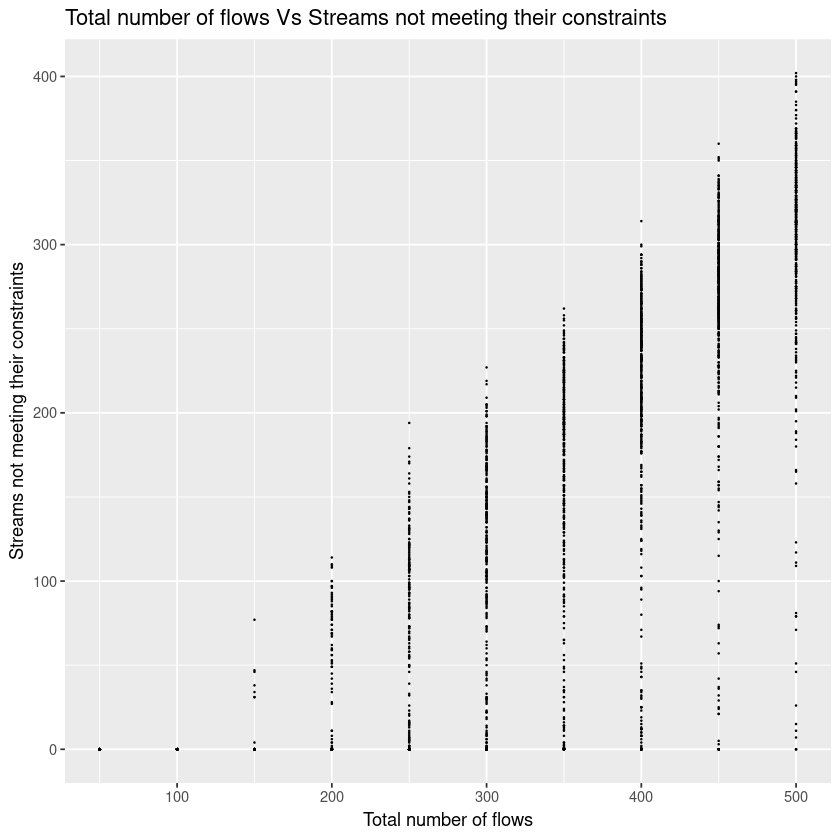

In [3]:
# scatterplot
plot <- ggplot(data, aes(x=totalIndividualFlows, y=ConcisePriorities3classes))
plot <- plot + ggtitle("Total number of flows Vs Streams not meeting their constraints")
plot <- plot + xlab("Total number of flows")
plot <- plot + ylab("Streams not meeting their constraints")
plot <- plot + geom_point(size=0.08)
#plot <- plot + geom_jitter(size=0.08)
plot

In the plot we can observe, that Total number of flows are grouped every 50 flows and differences in number of streams not meeting their constraints between these groups are quite visible. This causes big density of points in the plot (e.g. for x=50, there are multiple rows with Total number of flows equal 50). In this case, actual number of entries is rather hard to read, this plot in fact suggests, that number of feasible streams is relatively small. To make it more readable, I tried with jitter plot (below).

Jitter plot reveals at least one more information - actual number of feasible streams decreases with growing total number of flows - we are unable to get this information from scatter plot.

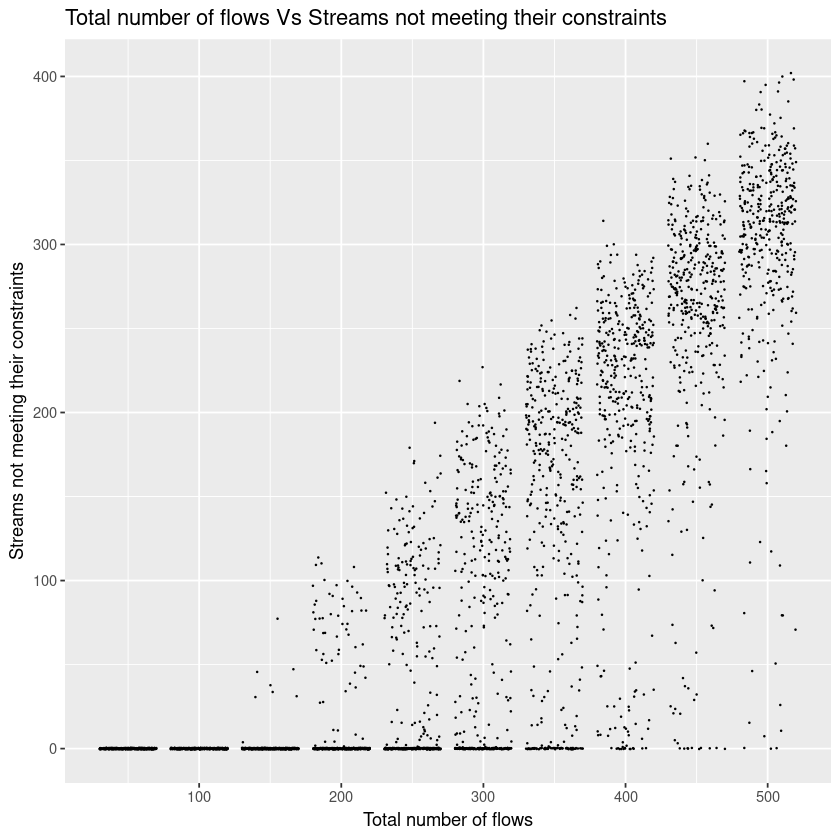

In [4]:
# jitterplot
plot1 <- ggplot(data, aes(x=totalIndividualFlows, y=ConcisePriorities3classes))
plot1 <- plot1 + ggtitle("Total number of flows Vs Streams not meeting their constraints")
plot1 <- plot1 + xlab("Total number of flows")
plot1 <- plot1 + ylab("Streams not meeting their constraints")
#plot1 <- plot1 + geom_point(size=0.08)
plot1 <- plot1 + geom_jitter(size=0.08)
plot1

In [5]:
# PCC
cat("PCC between Total number of flows and amount of streams not meating their constarints")
cor(data[1], data[ncol(data)])

PCC between Total number of flows and amount of streams not meating their constarints

,ConcisePriorities3classes
totalIndividualFlows,0.8369737


R squared coefficient

[1] 0.700525

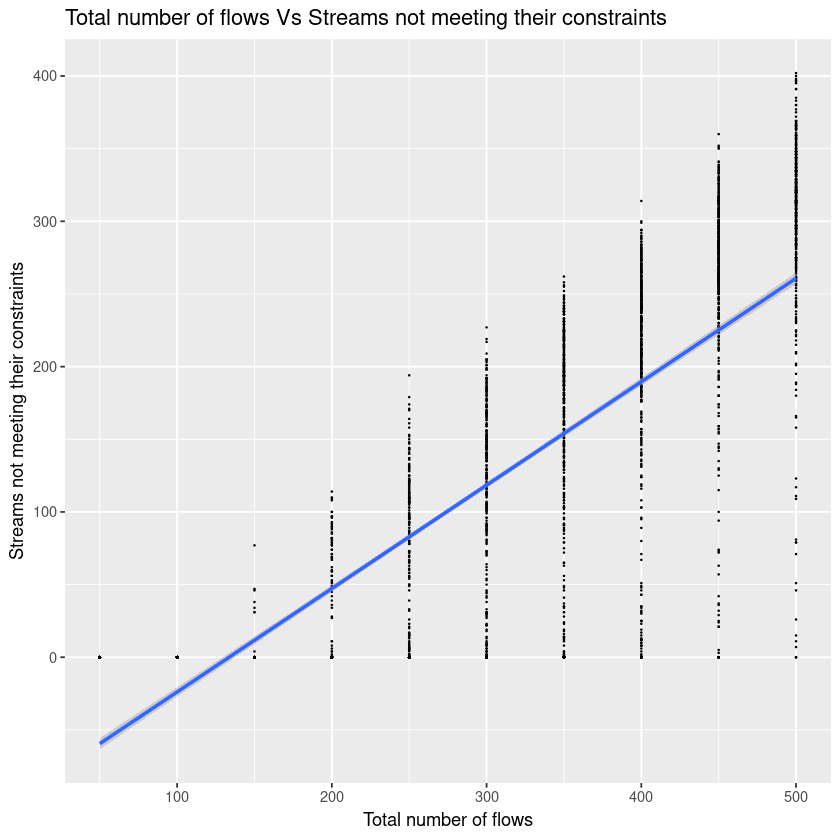

In [6]:
# regression model
reg <- lm(ConcisePriorities3classes ~ totalIndividualFlows,data=data)
cat("R squared coefficient")
summary(reg)$r.squared
# add regression line to scatterplot
plot <- plot + geom_smooth(method=lm, formula=y ~ x)
plot

Despite high value of R-square coefficient I think there is no substantial linear relationship in this data. Visual analysis revealed, that data are divided into two major groups - one for y=0 (feasible) and y between 100 and 350 (I call them "strongly" not-feasible). Below computations reveal, that number of elements it these two subsets is comparable. In my opinion, it is impossible to feat linear model in entire set of data, where we know that around half of them lays on line y=0. Moreover we have to remember that linear regression model is designed to fit mostly outliers values (it minimizes square of errors). 

I suppose it would be possible to fit linear model into subset of not-feasible data.

In [7]:
# number of categories
cat("Feasible")
sum(data[ncol(data)]==0)
cat("Not feasible")
sum(data[ncol(data)]!=0)

Feasible

[1] 2018

Not feasible

[1] 1982

## Classification with one round performance evaluation

In [8]:
# shuffle dataset and re-label rows
shuffled <- data[sample(nrow(data), replace=FALSE),]
row.names(shuffled) <- c(1:nrow(shuffled))

In [9]:
# min max normalization function
normalize <- function(dataset){
    mini = min(dataset)
    maxi = max(dataset)
    dif = maxi-mini
    return((dataset-mini)/dif)
}
#TEST
#normalize(c(1,2,3,4,5))

In [10]:
# normalizing data
shuffled_normalized <- shuffled
shuffled_normalized[,-ncol(shuffled)] = as.data.frame(lapply(shuffled[,-ncol(shuffled)], normalize))
# head(shuffled_normalized)

In [11]:
# split dataset
split <- 1000
train_features <- shuffled_normalized[c((split+1):nrow(shuffled_normalized)),-ncol(shuffled_normalized)]
train_target <- shuffled_normalized[c((split+1):nrow(shuffled_normalized)),ncol(shuffled_normalized)]
test_features <- shuffled_normalized[c(1:split),-ncol(shuffled_normalized)]
test_target <- shuffled_normalized[c(1:split),ncol(shuffled_normalized)]

### tests
# ncol(train_features)
# ncol(test_features)
# nrow(train_features)
# nrow(test_features)
#
# length(train_target)
# length(test_target)

### change targets to factors
# F - feasible [1]
# N - not feasible [0]

train_target <- factor(train_target==0, labels=c("N","F"))
test_target <- factor(test_target==0, labels=c("N","F"))

In [12]:
# knn function
train_test_knn <- function(train_features, train_target, test_features, test_target, k){
    test_pred <- knn(train_features, test_features, train_target, k=k)
    return(mean(test_pred == (test_target)))
}
# test
# train_test_knn(train_features, train_target, test_features, test_target, 21)

In [13]:
# setting up uniform testing features - by column index value
choose_features_vector <- c(2,3,4,5)
k_range <- c(3:50)

In [14]:
# knn with finding best k value
# choose features
temp_test_features <- test_features[,choose_features_vector]
temp_train_features <- train_features[,choose_features_vector]
values = c()
#ks = c(3:50)
for(k in k_range){
    values = c(values, c(train_test_knn(temp_train_features, train_target, 
                                        temp_test_features, test_target, k)))
}
max(values)
k_range[values == max(values)]

[1] 0.966

[1] 28 29 30 33 37 41

In [15]:
# initialize list for storing test predictions
test_pred_list <- vector('list',length(k_range)) 
values=c()

for(i in c(1:length(k_range))){
    test_pred_list[[i]] <- knn(train_features[,choose_features_vector], 
                               test_features[,choose_features_vector], (train_target), k_range[i])
    values = c(values, mean(test_pred_list[[i]]==(test_target)))
}

# print max value
cat("Max value of performance metric")
max(values)

# print k for max value
cat("k for max value")
k_range[values==max(values)]

# print crosstable for max value
CrossTable(x=test_pred_list[[match(max(values),values)]], y=(test_target), prop.chisq=FALSE)

Max value of performance metric

[1] 0.967

k for max value

[1] 28


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Row Total |
|           N / Col Total |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  1000 

 
                                             | (test_target) 
test_pred_list[[match(max(values), values)]] |         N |         F | Row Total | 
---------------------------------------------|-----------|-----------|-----------|
                                           N |       495 |        18 |       513 | 
                                             |     0.965 |     0.035 |     0.513 | 
                                             |     0.971 |     0.037 |           | 
                                             |     0.495 |     0.018 |           | 
---------------------------------------------|-----------|-----------|-----------|
                                           F |        15 |       472 |       487 | 
                                      

The detailed outcome of predictions with best fitting k value is presented in the table above. We can observe, that total percentage of mistakes was 3.3%, including 18 (1.8% total) feasible streams marked as non-feasible (false negative) and 15 (1.5% total) non-feasible streams marked as feasible (false positive).

After re-shuffling initial data, obtained results are likely to differ. 

### Experiments

In next 3 code cells I'm trying to enhance prediction performance by adding additional features. Following the rule, 
that good features are correlated with value to be predicted I compute PCC between each feature and that value (cell 2). Later in cell 3 I build and fit models (one feature per model), looking for best fit between these features and seeking best performing k value for each one.

We can observe, that default choice of features is very good, but it can possibly be enhanced by adding first column. Computations for this case were performed in cell 1. This time, received score is the same as for set of default features only, but more k values could give that high performance. Again results may differ after re-shuffling data.

In [16]:
# experiments
# choose features
temp_test_features <- test_features[,c(1,choose_features_vector)]
temp_train_features <- train_features[,c(1,choose_features_vector)]
values = c()
#ks = c(3:50)
for(k in k_range){
    values = c(values, c(train_test_knn(temp_train_features, train_target, 
                                        temp_test_features, test_target, k)))
}
max(values)
k_range[values == max(values)]

[1] 0.967

[1] 29 30 32 37 41 42 50

In [17]:
# print correlation between each feature and target
for(i in 1:15){
    cat(i,"\t",cor(shuffled_normalized[i], (shuffled_normalized[16]==0)),"\n")
}

1 	 -0.7929558 
2 	 -0.7683885 
3 	 -0.7030974 
4 	 -0.8125012 
5 	 -0.8295967 
6 	 -0.7047864 
7 	 -0.6982976 
8 	 -0.7105504 
9 	 -0.7020444 
10 	 -0.705093 
11 	 -0.7042763 
12 	 -0.7053392 
13 	 -0.7365225 
14 	 -0.7049835 
15 	 0.5394649 


In [18]:
# build a model for each feature with best k value
cat("Feature\t max value\tk values\n")
for(i in 1:15){
    values = c()
    ks = c(16:48)
    for(k in ks){
        values = c(values, c(train_test_knn(train_features[i], train_target, 
                                            test_features[i], test_target, k)))
    }
    cat(i,"\t",max(values),"\t",ks[values == max(values)],"\n")
}

Feature	 max value	k values
1 	 0.901 	 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 
2 	 0.889 	 28 31 
3 	 0.842 	 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 
4 	 0.913 	 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 
5 	 0.945 	 20 
6 	 0.816 	 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 37 38 39 40 41 42 43 44 45 46 47 48 
7 	 0.832 	 47 48 
8 	 0.846 	 46 47 
9 	 0.833 	 35 36 37 38 39 40 41 42 43 44 45 46 47 48 
10 	 0.808 	 39 41 44 
11 	 0.813 	 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 
12 	 0.817 	 46 
13 	 0.856 	 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 
14 	 0.812 	 45 46 47 48 
15 	 0.79 	 28 


## Classification with k-fold performance evaluation

In [19]:
# k-fold function
# input data normalized and shuffled
kfolds <- function(data, k, folds=10){
    folds_vec <- cut(c(1:nrow(data)), folds, labels=FALSE)

    res <- c()
    for(i in 1:folds){
        testing <- data[which(folds_vec==i,  arr.ind=TRUE),]
        training <- data[-which(folds_vec==i,  arr.ind=TRUE),]
        test_pred <- knn(training[,-ncol(data)], testing[,-ncol(data)], training[,ncol(data)]==0, k=k)
        # print(mean(test_pred == factor(testing[,ncol(data)])))
        res <- c(res, mean(test_pred == (testing[,ncol(data)]==0)))
    }
    return(mean(res))
}

In [20]:
# k-fold performing
sequenceOfNeighbors <- c(1,(1:10)*10)
acc = c()
for(k in sequenceOfNeighbors){
    acc = c(acc, kfolds(shuffled_normalized[,c(choose_features_vector,16)], k))
}
max(acc)
sequenceOfNeighbors[acc==max(acc)]

[1] 0.9565

[1] 70

In this case, number of neighbors that maximizes prediction rate with k-fold validation is 70 with prediction rate 95.65%.

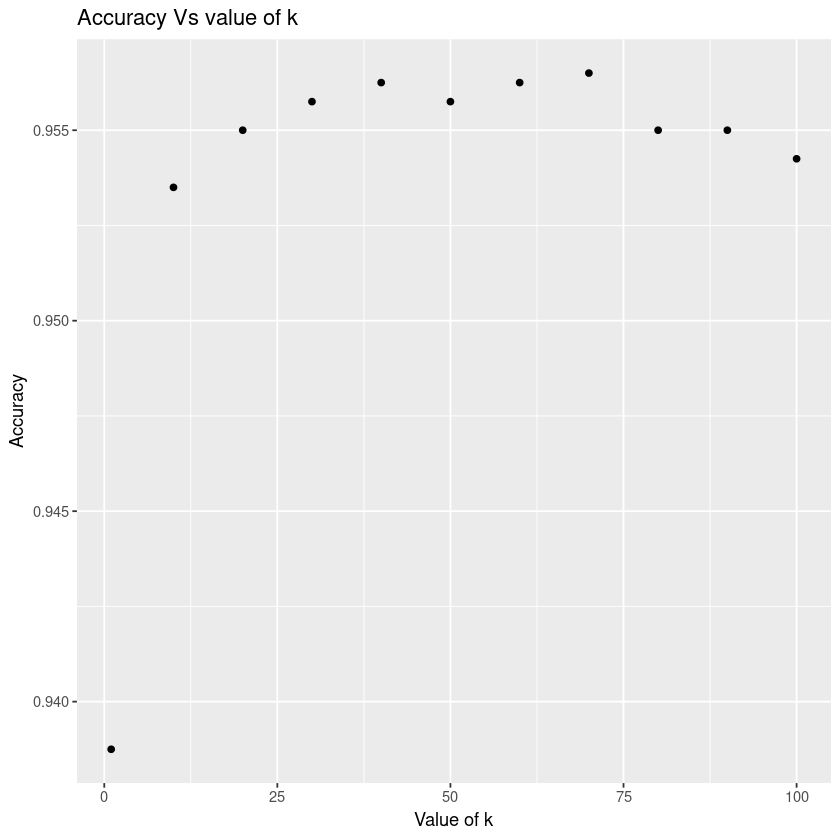

In [21]:
# plot
plot2 <- ggplot(mapping=aes(x=sequenceOfNeighbors,y=acc))
plot2 <- plot2 + geom_point()
plot2 <- plot2 + ggtitle("Accuracy Vs value of k")
plot2 <- plot2 + xlab("Value of k")
plot2 <- plot2 + ylab("Accuracy")
plot2

In [22]:
# applying z-score normalization
# z-score normalization
zScore <- function(dataset){
    return((dataset-mean(dataset))/sd(dataset))
}
###TEST
# zScore(c(1,2,3,4,5))
shuffled_z_score <- shuffled
shuffled_z_score[,-ncol(shuffled)] = as.data.frame(lapply(shuffled[,-ncol(shuffled)], zScore))

In [23]:
# k-fold performing with z-score normalization
acc2 = c()
for(k in sequenceOfNeighbors){
    acc2 = c(acc2, kfolds(shuffled_z_score[,c(choose_features_vector,16)], k))
}
max(acc2)
sequenceOfNeighbors[acc2==max(acc2)]

[1] 0.95725

[1] 40

We can observe, that in this particular case z-score improved prediction rate. However I doubt if it is statistically significant, because difference is minimal. Moreover, only 4 out of 11 results were improved with z-score normalization (last cell) and number of neighbors is different. Unfortunately to prove is it is significant, or not, further experiments would have to be performed, because this prediction rate is also sensible for initial shuffle of data. 

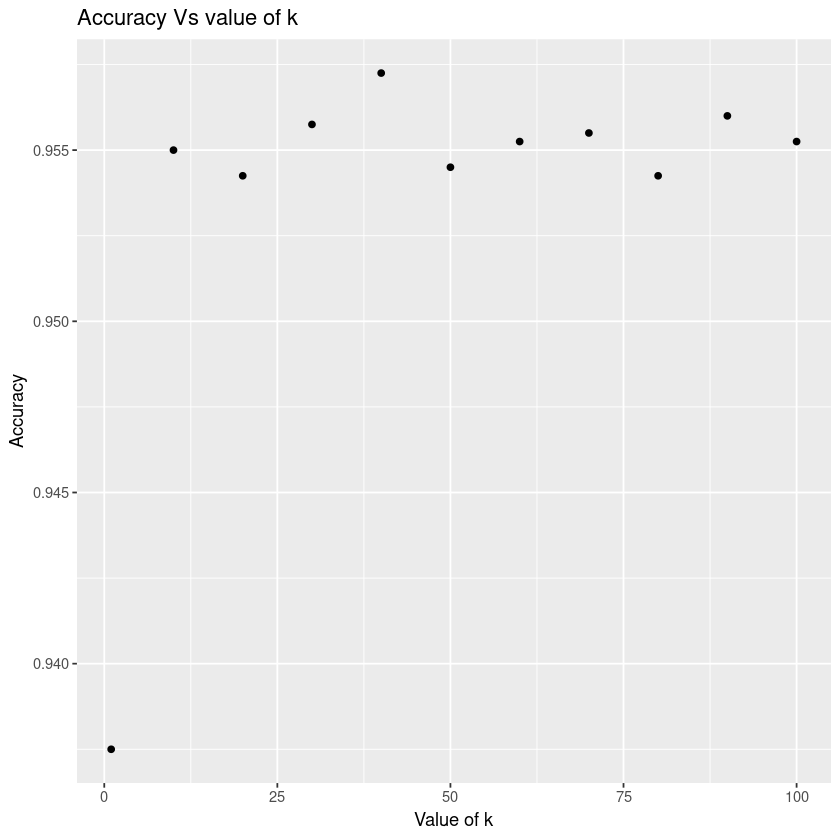

In [24]:
# plot
plot3 <- ggplot(mapping=aes(x=sequenceOfNeighbors,y=acc2))
plot3 <- plot3 + geom_point()
plot3 <- plot3+ ggtitle("Accuracy Vs value of k")
plot3 <- plot3+ xlab("Value of k")
plot3 <- plot3+ ylab("Accuracy")
plot3

In [25]:
# check where accuracy is imporved
sum(acc2>acc)

[1] 4